In [ ]:
#imports
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from math import sqrt
from hyperopt import hp
from hyperopt.pyll import scope
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn import linear_model
from catboost import CatBoostRegressor
from sklearn.preprocessing import PolynomialFeatures
import lightgbm as lgb
from sklearn.neural_network import MLPRegressor

import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from models.hyperopt_model import HyperoptModel
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr,  spearmanr,  kendalltau

The history saving thread hit an unexpected error (OperationalError('disk I/O error',)).History will not be written to the database.

In [ ]:
# read the data
preprocessed_data = pd.read_pickle('../data/preprocessed_twitter_qualitative.pd')

# Create a dataframe
df = pd.DataFrame(preprocessed_data)

In [3]:
# Create two new dataframes, one with the training rows, one with the test rows
train, test=train_test_split(df, test_size=0.2, random_state=0)

In [4]:
# Show the number of observations for the test and training dataframes
print('Number of observations in the training data:', len(train))
print('Number of observations in the test data:',len(test))

Number of observations in the training data: 18680
Number of observations in the test data: 4670


Cross-validated scores: [-0.6695262   0.0683415   0.11936241  0.07930832]
Average R^2 score: -0.100628493253


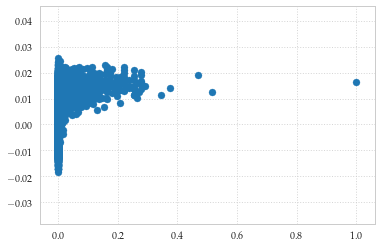

R2Score: 0.098090346515
RMSE: 0.018283407545741252


In [5]:
# Linear Regression 
dfLinear = df.copy()
y = dfLinear['score'].copy()
dfLinear.drop('score', axis=1, inplace=True) 

# create training and testing vars
X_train, X_test, y_train, y_test = train_test_split(dfLinear, y, test_size=0.2)

model = linear_model.LinearRegression()

scores = cross_val_score(model, dfLinear, y, cv=4)
print("Cross-validated scores:", scores)
print("Average R^2 score:", scores.mean())

predictions = cross_val_predict(model, dfLinear, y, cv=4)
plt.scatter(y, predictions)
plt.show()

accuracy = metrics.r2_score(y, predictions)
print("R2Score:", accuracy)
rmse = sqrt(metrics.mean_squared_error(y,  predictions))
print("RMSE:", rmse)

In [6]:
    #some parameters
    DO_LOWESS = False
    hyperopt = False
    # Run Lasso Regression with hyperopt optimization
    lasso = HyperoptModel(train.copy(), test.copy(),'lasso', cv=4, max_evals = 500)
    features = list(df)
    features.remove('score')

    lasso.pipeline = Pipeline([
        ('estimate', linear_model.Lasso(**{'alpha': 0.0006577184991258585}))
    ])
    
    lasso.raw_features = features
    lasso.space = {
        'estimate__alpha': hp.uniform('estimate__alpha', 0, 10),
    }

    if hyperopt:
        lasso.run(do_lowess=DO_LOWESS)
    else:
        # train with default params
        lasso.pipeline.fit(X=lasso.X_train, y=lasso.y_train)
        lasso.model = lasso.pipeline
        lasso.stats()
        lasso.plot_feature_importance()
        lasso.plot_predicted_vs_actual(do_lowess=DO_LOWESS)
        lasso.qq_plot()

Stats (train | test):
	R^2 score:		0.0641
					0.0683
	RMSE:			0.0192
					0.0162
	Mean error:		0.0061
					0.0058
	Pearson:		0.3272
					0.3158
	Spearman:		0.4171
					0.3861
	KendallTau:		0.2988
					0.2763

Plotting predicted vs. actual ...done

Plotting QQ ...done



In [7]:
    #some parameters
    DO_LOWESS = False
    hyperopt = False
    # Run Ridge Regression with hyperopt optimization
    ridge = HyperoptModel(train.copy(), test.copy(),'ridge', cv=4, max_evals = 500)
    features = list(df)
    features.remove('score')
    ridge.raw_features = features

    ridge.pipeline = Pipeline([
        ('estimate', linear_model.Ridge(**{'alpha': 0.05231780585024858}))
    ])
    
    ridge.space = {
        'estimate__alpha': hp.uniform('estimate__alpha', 0, 1000),
    }

    if hyperopt:
        ridge.run(do_lowess=DO_LOWESS)
    else:
        # train with default params
        ridge.pipeline.fit(X=ridge.X_train, y=ridge.y_train)
        ridge.model = ridge.pipeline
        ridge.stats()
        ridge.plot_feature_importance()
        ridge.plot_predicted_vs_actual(do_lowess=DO_LOWESS)
        ridge.qq_plot()

Stats (train | test):
	R^2 score:		0.1316
					0.1252
	RMSE:			0.0185
					0.0157
	Mean error:		0.0069
					0.0067
	Pearson:		0.3627
					0.3616
	Spearman:		0.5401
					0.5090
	KendallTau:		0.3963
					0.3747

Plotting predicted vs. actual ...done

Plotting QQ ...done



In [8]:
    #some parameters
    DO_LOWESS = False
    hyperopt = True
    # Run MLPRegressor with hyperopt optimization
    nn = HyperoptModel(train.copy(), test.copy(),'nn', cv=3, max_evals=500)
    features = list(df)
    features.remove('score')
    nn.raw_features = features

    nn.pipeline = Pipeline([
        ('estimate', MLPRegressor())
    ])
   
    nn.space = {
         'estimate__alpha' : hp.uniform('estimate__alpha', 0.001, 1),
         'estimate__activation' : hp.choice('estimate__activation', ['logistic']), # 'identity', 'logistic', 'tanh', 'relu'
         #'estimate__learning_rate' : hp.choice('estimate__learning_rate', ['constant', 'invscaling', 'adaptive']),
         'estimate__hidden_layer_sizes' : scope.int(hp.uniform('estimate__hidden_layer_sizes', 1, 100)),
         'estimate__solver' : hp.choice('estimate__solver', ['adam']), #'lbfgs', 'sgd',
         #'estimate__max_iter' : scope.int(hp.uniform('estimate__max_iter', 500, 1000))
    }

    if hyperopt:
        nn.run(do_lowess=DO_LOWESS)
    else:
        # train with default params
        nn.pipeline.fit(X=nn.X_train, y=nn.y_train)
        nn.model = cat.pipeline
        nn.stats()
        nn.plot_predicted_vs_actual(do_lowess=DO_LOWESS)
        nn.plot_feature_importance()
        nn.qq_plot()

Performing parameters optimization...
[1/500]	cv_eval_time=27.05 sec	RMSE=0.018951	R^2=0.091883
[2/500]	cv_eval_time=9.20 sec	RMSE=0.022085	R^2=-0.202193
[3/500]	cv_eval_time=21.14 sec	RMSE=0.018788	R^2=0.115084
[4/500]	cv_eval_time=15.78 sec	RMSE=0.019138	R^2=0.091916
[5/500]	cv_eval_time=18.42 sec	RMSE=0.019680	R^2=0.015775
[6/500]	cv_eval_time=14.81 sec	RMSE=0.018845	R^2=0.084925
[7/500]	cv_eval_time=12.38 sec	RMSE=0.018897	R^2=0.077898
[8/500]	cv_eval_time=13.84 sec	RMSE=0.018988	R^2=0.088052
[9/500]	cv_eval_time=17.35 sec	RMSE=0.018705	R^2=0.066939
[10/500]	cv_eval_time=11.11 sec	RMSE=0.018951	R^2=0.083654
[11/500]	cv_eval_time=18.08 sec	RMSE=0.018708	R^2=0.108409
[12/500]	cv_eval_time=15.26 sec	RMSE=0.018810	R^2=0.072860
[13/500]	cv_eval_time=11.45 sec	RMSE=0.018829	R^2=0.094304
[14/500]	cv_eval_time=10.14 sec	RMSE=0.019073	R^2=0.086572
[15/500]	cv_eval_time=16.32 sec	RMSE=0.018636	R^2=0.118667
[16/500]	cv_eval_time=18.84 sec	RMSE=0.019121	R^2=0.106907
[17/500]	cv_eval_time=9.64 

[139/500]	cv_eval_time=15.17 sec	RMSE=0.018893	R^2=0.087637
[140/500]	cv_eval_time=20.26 sec	RMSE=0.018719	R^2=0.112806
[141/500]	cv_eval_time=8.61 sec	RMSE=0.019007	R^2=0.013075
[142/500]	cv_eval_time=18.85 sec	RMSE=0.018744	R^2=0.112394
[143/500]	cv_eval_time=17.23 sec	RMSE=0.018955	R^2=0.101984
[144/500]	cv_eval_time=17.63 sec	RMSE=0.018845	R^2=0.093647
[145/500]	cv_eval_time=6.63 sec	RMSE=0.019614	R^2=-0.295643
[146/500]	cv_eval_time=17.65 sec	RMSE=0.018727	R^2=0.110810
[147/500]	cv_eval_time=14.44 sec	RMSE=0.018836	R^2=0.111211
[148/500]	cv_eval_time=11.75 sec	RMSE=0.019109	R^2=0.110408
[149/500]	cv_eval_time=13.76 sec	RMSE=0.018709	R^2=0.118103
[150/500]	cv_eval_time=17.47 sec	RMSE=0.018660	R^2=0.090290
[151/500]	cv_eval_time=18.49 sec	RMSE=0.018917	R^2=0.105706
[152/500]	cv_eval_time=15.74 sec	RMSE=0.018733	R^2=0.101715
[153/500]	cv_eval_time=16.03 sec	RMSE=0.018844	R^2=0.107308
[154/500]	cv_eval_time=12.56 sec	RMSE=0.018803	R^2=0.115355
[155/500]	cv_eval_time=12.04 sec	RMSE=0.0

[276/500]	cv_eval_time=8.72 sec	RMSE=0.021339	R^2=-0.703101
[277/500]	cv_eval_time=15.81 sec	RMSE=0.018610	R^2=0.115533
[278/500]	cv_eval_time=15.80 sec	RMSE=0.018806	R^2=0.074096
[279/500]	cv_eval_time=7.76 sec	RMSE=0.019980	R^2=0.079070
[280/500]	cv_eval_time=20.23 sec	RMSE=0.018654	R^2=0.098007
[281/500]	cv_eval_time=22.06 sec	RMSE=0.018729	R^2=0.093983
[282/500]	cv_eval_time=14.25 sec	RMSE=0.019243	R^2=0.118859
[283/500]	cv_eval_time=14.93 sec	RMSE=0.018770	R^2=0.101388
[284/500]	cv_eval_time=17.45 sec	RMSE=0.018918	R^2=0.004014
[285/500]	cv_eval_time=7.51 sec	RMSE=0.018988	R^2=0.053692
[286/500]	cv_eval_time=19.62 sec	RMSE=0.018751	R^2=0.117393
[287/500]	cv_eval_time=18.59 sec	RMSE=0.018745	R^2=0.112638
[288/500]	cv_eval_time=19.71 sec	RMSE=0.018772	R^2=0.076360
[289/500]	cv_eval_time=8.57 sec	RMSE=0.020030	R^2=0.076417
[290/500]	cv_eval_time=19.09 sec	RMSE=0.018693	R^2=0.105134
[291/500]	cv_eval_time=12.89 sec	RMSE=0.018770	R^2=0.078730
[292/500]	cv_eval_time=16.04 sec	RMSE=0.018

[413/500]	cv_eval_time=17.11 sec	RMSE=0.018738	R^2=0.085622
[414/500]	cv_eval_time=17.13 sec	RMSE=0.018806	R^2=0.108874
[415/500]	cv_eval_time=9.74 sec	RMSE=0.020070	R^2=0.101190
[416/500]	cv_eval_time=14.67 sec	RMSE=0.019030	R^2=0.096092
[417/500]	cv_eval_time=8.16 sec	RMSE=0.019439	R^2=0.057856
[418/500]	cv_eval_time=17.47 sec	RMSE=0.018760	R^2=0.115274
[419/500]	cv_eval_time=16.96 sec	RMSE=0.019168	R^2=0.082620
[420/500]	cv_eval_time=18.42 sec	RMSE=0.018969	R^2=0.114714
[421/500]	cv_eval_time=17.52 sec	RMSE=0.018665	R^2=0.120664
[422/500]	cv_eval_time=8.62 sec	RMSE=0.018950	R^2=0.051156
[423/500]	cv_eval_time=15.28 sec	RMSE=0.019666	R^2=0.106393
[424/500]	cv_eval_time=18.02 sec	RMSE=0.018933	R^2=0.117468
[425/500]	cv_eval_time=18.44 sec	RMSE=0.018789	R^2=0.108936
[426/500]	cv_eval_time=15.62 sec	RMSE=0.019327	R^2=0.104628
[427/500]	cv_eval_time=19.54 sec	RMSE=0.018752	R^2=0.095729
[428/500]	cv_eval_time=10.55 sec	RMSE=0.019278	R^2=0.090162
[429/500]	cv_eval_time=16.69 sec	RMSE=0.019

In [9]:
    #some parameters
    DO_LOWESS = False
    hyperopt = True
    # Run CatBoostRegressor with hyperopt optimization
    cat = HyperoptModel(train.copy(), test.copy(),'cat', cv=3, max_evals = 30)

    cat.pipeline = Pipeline([
        ('estimate', CatBoostRegressor())
    ])
    
    features = list(df)
    features.remove('score')
    cat.raw_features = features
    
    cat.space = {
        'estimate__iterations': hp.choice('estimate__iterations', [1300]),
        'estimate__loss_function': hp.choice('estimate__loss_function', ['RMSE']),
        'estimate__train_dir': hp.choice('estimate__train_dir', ['outputs/cat']),
        'estimate__thread_count': hp.choice('estimate__thread_count', [4]),
        'estimate__used_ram_limit': hp.choice('estimate__used_ram_limit', [1024 * 1024 * 1024 * 4]),  # 4gb
        'estimate__random_seed': hp.choice('estimate__random_seed', [0]),

        'estimate__learning_rate': hp.loguniform('estimate__learning_rate', -5, 0),
        'estimate__random_strength': hp.choice('estimate__random_strength', [1, 20]),
        'estimate__l2_leaf_reg': hp.loguniform('estimate__l2_leaf_reg', 0, np.log(10)),
        'estimate__bagging_temperature': hp.uniform('estimate__bagging_temperature', 0, 1),
    }

    """
    find the best number of trees (following https://tech.yandex.com/catboost/doc/dg/concepts/parameter-tuning_trees-number-docpage/#parameter-tuning_trees-number)
    need to also substitute the CatBoostRegressor parameters with:
        ('estimate', CatBoostRegressor(iterations=10000, loss_function='RMSE', auto_stop_pval=1e-4, use_best_model=True, train_dir='outputs/cat_trees', verbose=True))
    """
    # num_trees_train, num_trees_eval = train_test_split(train, test_size=0.2, random_state=0)
    # X = num_trees_train[list(filter(lambda column: column in cat.raw_features, cat.train.columns))]
    # y = num_trees_train['score']
    #
    # eval_X = num_trees_eval[list(filter(lambda column: column in cat.raw_features, cat.train.columns))]
    # eval_X = cat.pipeline.named_steps['prepare_features'].fit_transform(eval_X)
    # eval_set = (eval_X, num_trees_eval['score'])
    #
    # cat.pipeline.fit(X=X, y=y, estimate__eval_set=eval_set)
    # cat.model = cat.pipeline
    # print(cat.model.named_steps['estimate'].get_params())
    # cat.model.named_steps['estimate'].save_model('tmp/cat.model'.encode('utf-8'))

    if hyperopt:
        cat.run(do_lowess=DO_LOWESS)
    else:
        # train with default params
        cat.pipeline.fit(X=cat.X_train, y=cat.y_train)
        cat.model = cat.pipeline
        cat.stats()
        cat.plot_predicted_vs_actual(do_lowess=DO_LOWESS)
        cat.plot_feature_importance()
        #cat.qq_plot()

Performing parameters optimization...
[1/30]	cv_eval_time=387.06 sec	RMSE=0.015880	R^2=0.334603
[2/30]	cv_eval_time=384.17 sec	RMSE=0.015265	R^2=0.415918
[3/30]	cv_eval_time=385.98 sec	RMSE=0.015238	R^2=0.434492
[4/30]	cv_eval_time=389.97 sec	RMSE=0.015472	R^2=0.400987
[5/30]	cv_eval_time=384.81 sec	RMSE=0.015447	R^2=0.390772
[6/30]	cv_eval_time=385.79 sec	RMSE=0.015289	R^2=0.434449
[7/30]	cv_eval_time=389.78 sec	RMSE=0.015927	R^2=0.374939
[8/30]	cv_eval_time=395.95 sec	RMSE=0.014795	R^2=0.407311
[9/30]	cv_eval_time=391.67 sec	RMSE=0.015325	R^2=0.417973
[10/30]	cv_eval_time=386.25 sec	RMSE=0.014873	R^2=0.421241
[11/30]	cv_eval_time=388.14 sec	RMSE=0.015178	R^2=0.393942
[12/30]	cv_eval_time=392.53 sec	RMSE=0.015417	R^2=0.423639
[13/30]	cv_eval_time=407.57 sec	RMSE=0.015197	R^2=0.410555
[14/30]	cv_eval_time=389.01 sec	RMSE=0.015594	R^2=0.414910
[15/30]	cv_eval_time=389.38 sec	RMSE=0.015209	R^2=0.430063
[16/30]	cv_eval_time=387.23 sec	RMSE=0.016018	R^2=0.321078
[17/30]	cv_eval_time=438.15

In [10]:
    #some parameters
    DO_LOWESS = False
    hyperopt = True
    # Run LGBMRegressor with hyperopt optimization
    lgbm = HyperoptModel(train.copy(), test.copy(), 'lgbm', cv=3, max_evals=50)
    lgbm.pipeline = Pipeline([
        ('estimate', lgb.LGBMRegressor())
    ])
    
    features = list(df)
    features.remove('score')
    lgbm.raw_features = features
   
    """ find number of trees """
    # num_trees_train, num_trees_eval = train_test_split(train, test_size=0.2, random_state=0)
    # X = num_trees_train[list(filter(lambda column: column in lgbm.raw_features, lgbm.train.columns))]
    # y = num_trees_train['score']
    #
    # eval_X = num_trees_eval[list(filter(lambda column: column in lgbm.raw_features, lgbm.train.columns))]
    # eval_X = lgbm.pipeline.named_steps['prepare_features'].fit_transform(eval_X)
    # eval_set = (eval_X, num_trees_eval['score'])
    #
    # best = lgbm.pipeline.fit(X=X, y=y, estimate__eval_set=eval_set, estimate__early_stopping_rounds=10)
    # print(best.named_steps['estimate'].best_iteration)

    lgbm.space = {
        'estimate__objective': hp.choice('estimate__objective', ['regression']),
        'estimate__n_estimators': hp.choice('estimate__n_estimators', [400]),
        'estimate__seed': hp.choice('estimate__seed', [0]),

        'estimate__learning_rate': hp.loguniform('estimate__learning_rate', -7, 0),
        'estimate__num_leaves': scope.int(hp.qloguniform('estimate__num_leaves', 1, 7, 1)),
        'estimate__feature_fraction': hp.uniform('estimate__feature_fraction', 0.5, 1),
        'estimate__bagging_fraction': hp.uniform('estimate__bagging_fraction', 0.5, 1),
        'estimate__min_data_in_leaf': scope.int(hp.qloguniform('estimate__min_data_in_leaf', 0, 6, 1)),
        'estimate__min_sum_hessian_in_leaf': hp.loguniform('estimate__min_sum_hessian_in_leaf', -16, 5),
        'estimate__lambda_l1': hp.choice('lambda_l1', [0, hp.loguniform('estimate__lambda_l1_positive', -16, 2)]),
        'estimate__lambda_l2': hp.choice('lambda_l2', [0, hp.loguniform('estimate__lambda_l2_positive', -16, 2)]),
    }

    if hyperopt:
        lgbm.run(do_lowess=DO_LOWESS)
    else:
        # train with default params
        lgbm.pipeline.fit(X=lgbm.X_train, y=lgbm.y_train)
        lgbm.model = lgbm.pipeline
        lgbm.stats()
        lgbm.plot_predicted_vs_actual()
        lgbm.plot_feature_importance()

Performing parameters optimization...
[1/50]	cv_eval_time=226.71 sec	RMSE=0.015840	R^2=0.373715
[2/50]	cv_eval_time=296.80 sec	RMSE=0.018477	R^2=0.135480
[3/50]	cv_eval_time=2129.09 sec	RMSE=0.015936	R^2=0.358820
[4/50]	cv_eval_time=548.25 sec	RMSE=0.015888	R^2=0.355870
[5/50]	cv_eval_time=8824.00 sec	RMSE=0.015701	R^2=0.382719
[6/50]	cv_eval_time=235.58 sec	RMSE=0.015687	R^2=0.365468
[7/50]	cv_eval_time=1849.63 sec	RMSE=0.018288	R^2=0.159059
[8/50]	cv_eval_time=1587.69 sec	RMSE=0.015939	R^2=0.330191
[9/50]	cv_eval_time=95.76 sec	RMSE=0.018411	R^2=0.141265
[10/50]	cv_eval_time=22.26 sec	RMSE=0.015736	R^2=0.368188
[11/50]	cv_eval_time=39.48 sec	RMSE=0.017068	R^2=0.271507
[12/50]	cv_eval_time=93.88 sec	RMSE=0.017071	R^2=0.234946
[13/50]	cv_eval_time=201.62 sec	RMSE=0.015881	R^2=0.367333
[14/50]	cv_eval_time=80.17 sec	RMSE=0.016030	R^2=0.355815
[15/50]	cv_eval_time=35.59 sec	RMSE=0.019340	R^2=-0.005547
[16/50]	cv_eval_time=1180.34 sec	RMSE=0.016484	R^2=0.268919
[17/50]	cv_eval_time=44831.

In [4]:
    #Polynomial linear regression 
    degrees = 4
    for d in range(1, degrees+1):
            print("Degree: %s" % d)
            # Create the model, split the sets and fit it
            polynomial_features = PolynomialFeatures(
                degree=d, include_bias=False
            )
            linear_regression = linear_model.LinearRegression()
            model = Pipeline([
                ("polynomial_features", polynomial_features),
                ("linear_regression", linear_regression)
            ])
            dfPoly = df.copy()
            y = dfPoly['score'].copy()
            dfPoly.drop('score', axis=1, inplace=True) 

            # create training and testing vars
            X_train, X_test, y_train, y_test = train_test_split(dfPoly, y, test_size=0.2)

            model.fit(X_train, y_train)
            # Calculate the metrics
            train_prediction = model.predict(X_train)
            test_prediction = model.predict(X_test)
            
            print('Polynomial degree: {}'.format(d))
            print('Stats (train | test):')
            print('\tR^2 score:\t\t%.4f\n\t\t\t\t\t%.4f' % (r2_score(y_train, train_prediction),
                                                        r2_score(y_test, test_prediction)))
            print('\tRMSE:\t\t\t%.4f\n\t\t\t\t\t%.4f' % (mean_squared_error(y_train, train_prediction) ** 0.5,
                                                     mean_squared_error(y_test, test_prediction) ** 0.5))
            print('\tMean error:\t\t%.4f\n\t\t\t\t\t%.4f' % (mean_absolute_error(y_train, train_prediction),
                                                         mean_absolute_error(y_test, test_prediction)))
            print('\tPearson:\t\t%.4f\n\t\t\t\t\t%.4f' % (pearsonr(y_train, train_prediction)[0],
                                                         pearsonr(y_test, test_prediction)[0]))
            print('\tSpearman:\t\t%.4f\n\t\t\t\t\t%.4f' % (spearmanr(y_train, train_prediction)[0],
                                                         spearmanr(y_test, test_prediction)[0]))
            print('\tKendallTau:\t\t%.4f\n\t\t\t\t\t%.4f' % (kendalltau(y_train, train_prediction)[0],
                                                         kendalltau(y_test, test_prediction)[0]))

Degree: 1
Polynomial degree: 1
Stats (train | test):
	R^2 score:		0.1306
					0.1323
	RMSE:			0.0181
					0.0173
	Mean error:		0.0068
					0.0067
	Pearson:		0.3614
					0.3642
	Spearman:		0.5369
					0.5296
	KendallTau:		0.3942
					0.3900
Degree: 2
Polynomial degree: 2
Stats (train | test):
	R^2 score:		0.2221
					0.1979
	RMSE:			0.0172
					0.0164
	Mean error:		0.0060
					0.0065
	Pearson:		0.4713
					0.4545
	Spearman:		0.4267
					0.4587
	KendallTau:		0.3044
					0.3283
Degree: 3
Polynomial degree: 3
Stats (train | test):
	R^2 score:		0.3638
					-17055.7104
	RMSE:			0.0154
					2.4795
	Mean error:		0.0062
					0.0898
	Pearson:		0.6032
					0.0045
	Spearman:		0.3417
					0.2311
	KendallTau:		0.2393
					0.1635
Degree: 4


MemoryError: 